In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

from dogo.results import get_pred_means_and_vars, get_experiment_details

In [3]:
plt.rc('font', size=16)

In [4]:
STATE_DIMS = 17
ACTION_DIMS = 6
REWARD_DIMS = 1
TERMINAL_DIMS = 1

DIMS = [STATE_DIMS, ACTION_DIMS, STATE_DIMS, REWARD_DIMS, TERMINAL_DIMS]
ENDS = np.cumsum(DIMS)

# D3RLPY-PAP5

In [5]:
d3rlpy_pap5_datasets = [
    "D3RLPY-PAP5",
    "D3RLPY-PAP5-P0-3",
    "D3RLPY-PAP5-P1-4",
    "D3RLPY-PAP5_100000",
    "D3RLPY-PAP5-P0_25000",
    "D3RLPY-PAP5-P1_25000",
    "D3RLPY-PAP5-P2_25000",
    "D3RLPY-PAP5-P3_25000",
    "D3RLPY-PAP5-P4_25000",
    "D3RLPY-PAP5-P0_100000",
    "D3RLPY-PAP5-P1_100000",
    "D3RLPY-PAP5-P2_100000",
    "D3RLPY-PAP5-P3_100000",
    "D3RLPY-PAP5-P4_100000",
]
d3rlpy_pap5_experiment_datasets = ['D3RLPY-PAP5-P0-3', 'D3RLPY-PAP5-P1-4']
d3rlpy_pap5_experiments = ["MP100", "MP101", "MP102", "MP103", "MP104", "MP105", "MP106", "MP107", "MP108", "MP109", "MP110", "MP111", "MP134", "MP135", "MP136", "MP137", "MP138", "MP139"]#, "MP124", "MP125", "MP126"]

In [6]:
d3rlpy_pap5_preds = {}
d3rlpy_pap5_pred_summary = {}
for exp in d3rlpy_pap5_experiments:
    d3rlpy_pap5_preds[exp] = {}
    
    exp_details = get_experiment_details(exp, get_elites=True)
    elites = exp_details.elites
    key = ' - '.join((exp_details.name, exp_details.dataset, f'REx: {exp_details.rex}'))
    for data in d3rlpy_pap5_datasets:
        pred_means, pred_vars = get_pred_means_and_vars(exp, data)

        d3rlpy_pap5_preds[exp][data] = {
            'pred_means': pred_means[elites, :, :],
            'pred_vars': pred_vars[elites, :, :],
        }

        d3rlpy_pap5_pred_summary[(key, data)] = {
            'experiment': exp_details.name,
            'rex': exp_details.rex,
            'rex_beta': exp_details.rex_beta or 0.,
            'training_dataset': exp_details.dataset,
            'seed': exp_details.seed,
            'mean_pred_means': pred_means.mean(),
            'mean_pred_vars': pred_vars.mean(),
            'median_pred_means': np.percentile(pred_means, 50),
            'median_pred_vars': np.percentile(pred_vars, 50)
        }


In [7]:
d3rlpy_pap5_pred_summary_df = (
    pd.DataFrame().from_dict(d3rlpy_pap5_pred_summary, orient='index').
    reset_index().rename(columns={'level_0': 'key', 'level_1': 'evaluation_dataset'})
)

In [8]:
d3rlpy_pap5_preds_groups = (
    d3rlpy_pap5_pred_summary_df[['rex', 'rex_beta', 'training_dataset', 'evaluation_dataset', 'seed', 'mean_pred_means', 'mean_pred_vars', 'median_pred_means', 'median_pred_vars']].
    groupby(['rex', 'rex_beta', 'training_dataset', 'evaluation_dataset'])
    # groupby(['rex', 'training_dataset', 'evaluation_dataset'])
)
d3rlpy_pap5_preds_avgs_df = d3rlpy_pap5_preds_groups.mean().reset_index()
d3rlpy_pap5_preds_stds_df = d3rlpy_pap5_preds_groups.std().reset_index().replace(np.NaN, 0)
d3rlpy_pap5_preds_mins_df = d3rlpy_pap5_preds_groups.min().reset_index().replace(np.NaN, 0)
d3rlpy_pap5_preds_maxes_df = d3rlpy_pap5_preds_groups.max().reset_index().replace(np.NaN, 0)

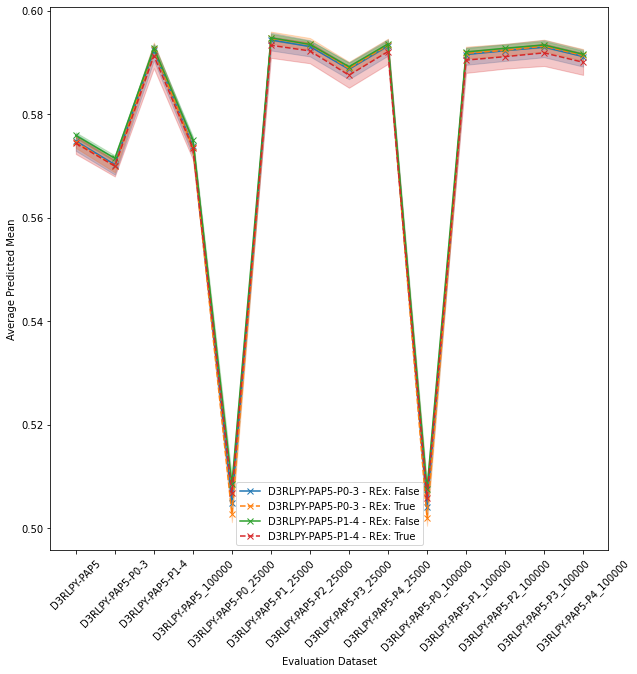

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

metric = 'mean_pred_means'
training_datasets = d3rlpy_pap5_experiment_datasets
evaluation_datasets = d3rlpy_pap5_datasets
for t_ds in training_datasets:
    for rex, rex_beta in [(False, 0.), (True, 10.)]:
        mask = (
            (d3rlpy_pap5_preds_avgs_df['training_dataset'] == t_ds) &
            (d3rlpy_pap5_preds_avgs_df['rex'] == rex) &
            (d3rlpy_pap5_preds_avgs_df['rex_beta'] == rex_beta) &
            # (d3rlpy_pap5_preds_avgs_df['seed'] == 4321) &
            (d3rlpy_pap5_preds_avgs_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
        )
        plot_means = d3rlpy_pap5_preds_avgs_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_mins = d3rlpy_pap5_preds_mins_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_maxes = d3rlpy_pap5_preds_maxes_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        label = f'{t_ds} - REx: {rex}'
        p = ax.plot(evaluation_datasets, plot_means, label=label, marker='x', ls='--' if rex else '-')
        ax.fill_between(evaluation_datasets, plot_mins, plot_maxes, color=p[0].get_color(), alpha=0.25)
ax.set_xticks(ax.get_xticks(), evaluation_datasets, rotation=45)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Average Predicted Mean')
ax.legend()

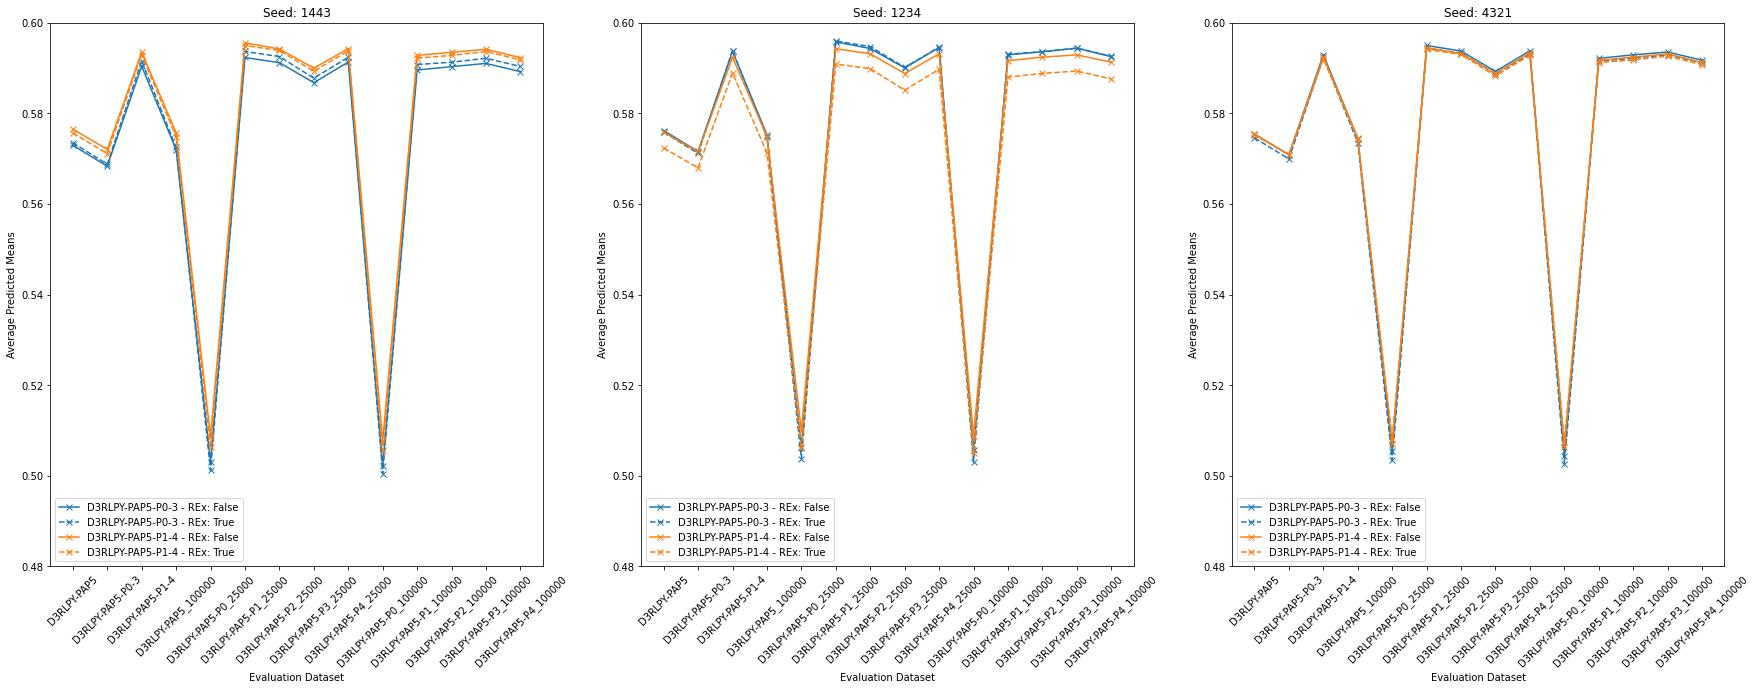

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'mean_pred_means'
training_datasets = ['D3RLPY-PAP5-P0-3', 'D3RLPY-PAP5-P1-4']
evaluation_datasets = d3rlpy_pap5_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex, rex_beta in [(False, 0.), (True, 10.)]:
            mask = (
                (d3rlpy_pap5_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_pap5_pred_summary_df['rex'] == rex) &
                (d3rlpy_pap5_pred_summary_df['rex_beta'] == rex_beta) &
                (d3rlpy_pap5_pred_summary_df['seed'] == seed) &
                (d3rlpy_pap5_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_pap5_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Average Predicted Means')
    ax[i].set_ylim(0.48, 0.6)
    ax[i].legend()

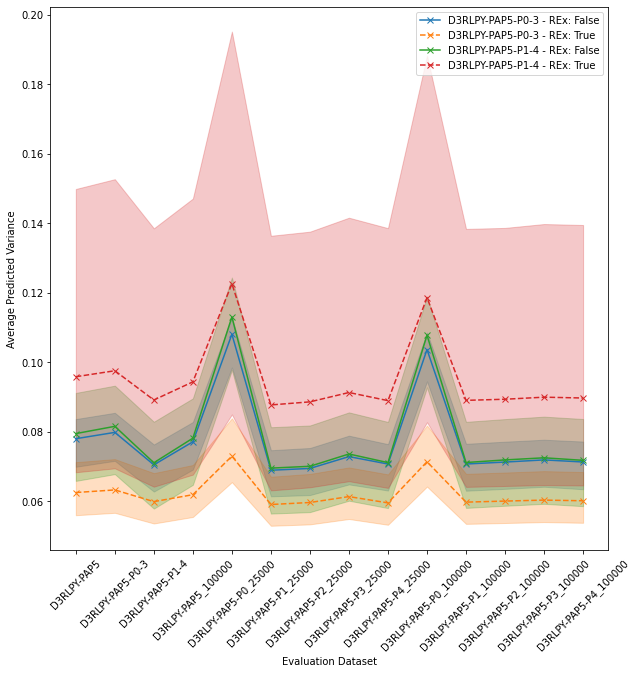

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

metric = 'mean_pred_vars'
training_datasets = d3rlpy_pap5_experiment_datasets
evaluation_datasets = d3rlpy_pap5_datasets
for t_ds in training_datasets:
    for rex, rex_beta in [(False, 0.), (True, 10.)]:
        mask = (
            (d3rlpy_pap5_preds_avgs_df['training_dataset'] == t_ds) &
            (d3rlpy_pap5_preds_avgs_df['rex'] == rex) &
            (d3rlpy_pap5_preds_avgs_df['rex_beta'] == rex_beta) &
            (d3rlpy_pap5_preds_avgs_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
        )
        plot_means = d3rlpy_pap5_preds_avgs_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_mins = d3rlpy_pap5_preds_mins_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_maxes = d3rlpy_pap5_preds_maxes_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        label = f'{t_ds} - REx: {rex}'
        p = ax.plot(evaluation_datasets, plot_means, label=label, marker='x', ls='--' if rex else '-')
        ax.fill_between(evaluation_datasets, plot_mins, plot_maxes, color=p[0].get_color(), alpha=0.25)
ax.set_xticks(ax.get_xticks(), evaluation_datasets, rotation=45)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Average Predicted Variance')
ax.legend()

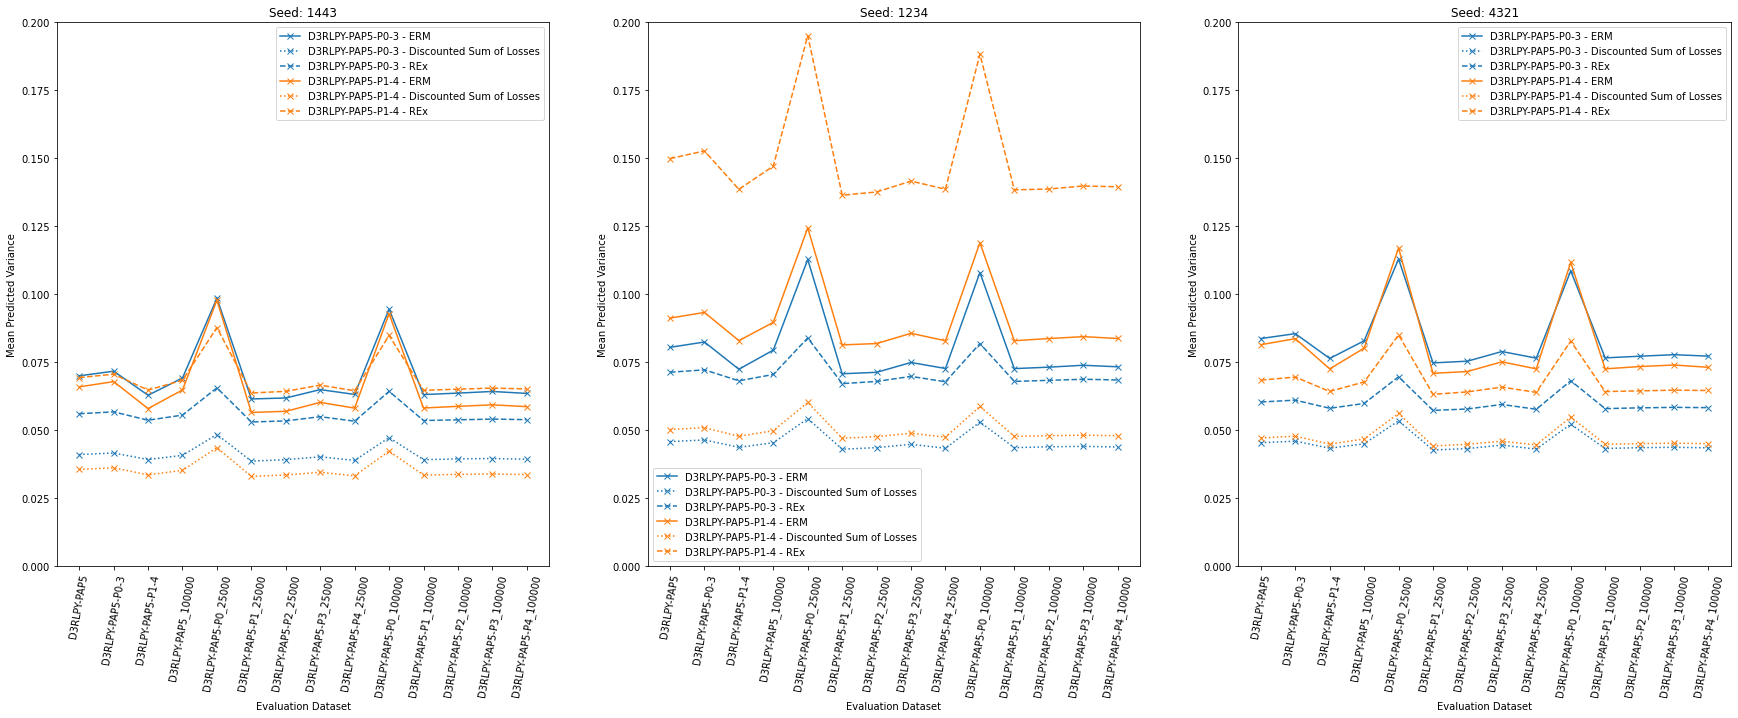

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

cols = [u'#1f77b4', u'#ff7f0e']
lss =  ['-', ':', '--']
labels = ['ERM', 'Discounted sum of Risks', 'REx']

metric = 'mean_pred_vars'
training_datasets = ['D3RLPY-PAP5-P0-3', 'D3RLPY-PAP5-P1-4']
evaluation_datasets = d3rlpy_pap5_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for j, t_ds in enumerate(training_datasets):
        for k, (rex, rex_beta) in enumerate([(False, 0.), (False, 10.), (True, 10.)]):
            mask = (
                (d3rlpy_pap5_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_pap5_pred_summary_df['rex'] == rex) &
                (d3rlpy_pap5_pred_summary_df['rex_beta'] == rex_beta) &
                (d3rlpy_pap5_pred_summary_df['seed'] == seed) &
                (d3rlpy_pap5_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_pap5_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - {labels[k]}'
            p = ax[i].plot(
                evaluation_datasets, plot_vals, label=label, marker='x',
                ls=lss[k],
                c=cols[j]
            )
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=80)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Mean Predicted Variance')
    ax[i].set_ylim(0, 0.2)
    ax[i].legend()

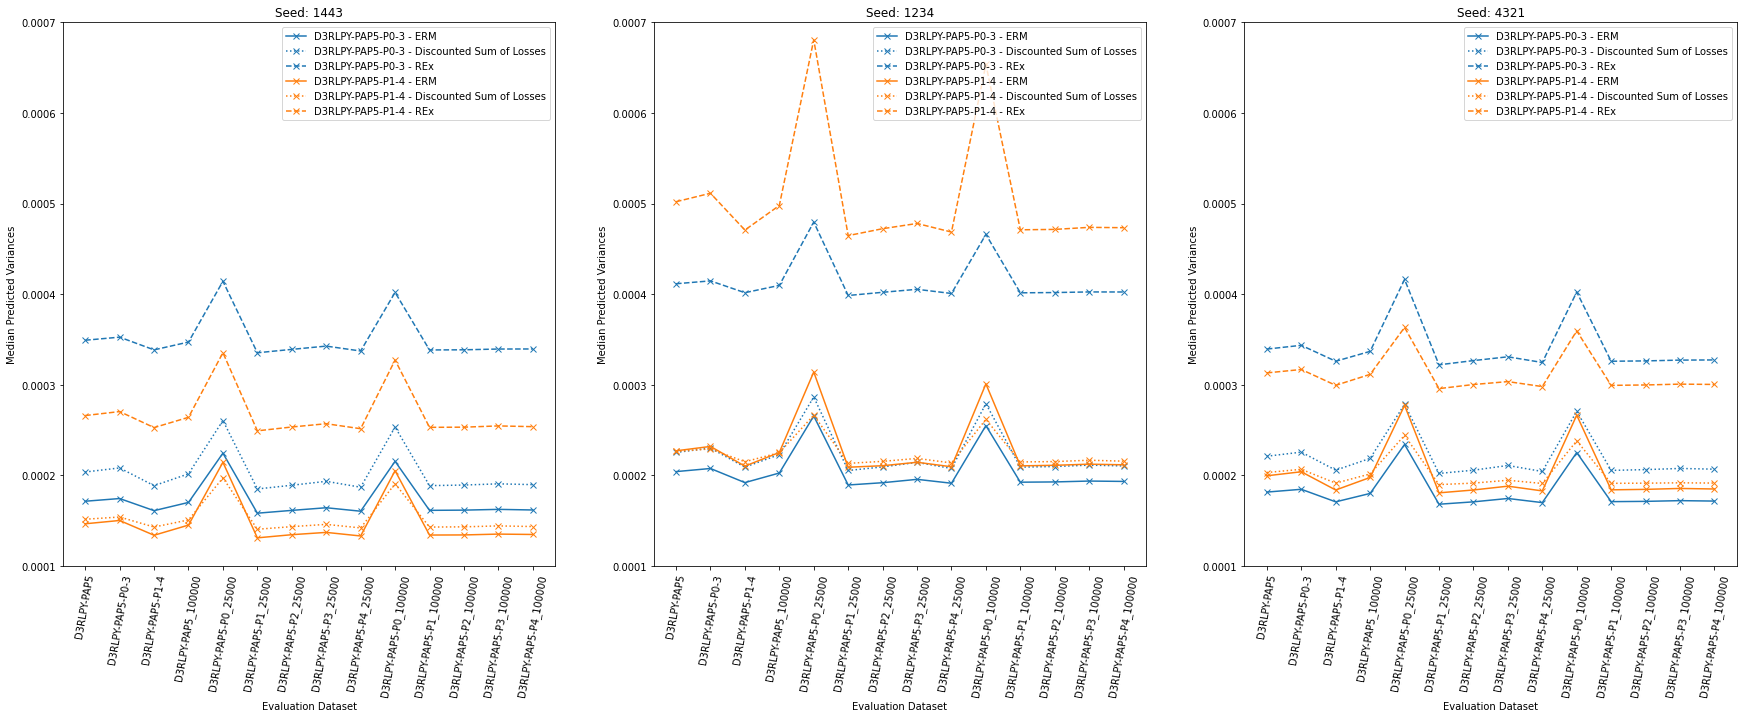

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

cols = [u'#1f77b4', u'#ff7f0e']
lss =  ['-', ':', '--']
labels = ['ERM', 'Discounted sum of Risks', 'REx']

metric = 'median_pred_vars'
training_datasets = ['D3RLPY-PAP5-P0-3', 'D3RLPY-PAP5-P1-4']
evaluation_datasets = d3rlpy_pap5_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for j, t_ds in enumerate(training_datasets):
        for k, (rex, rex_beta) in enumerate([(False, 0.), (False, 10.), (True, 10.)]):
            mask = (
                (d3rlpy_pap5_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_pap5_pred_summary_df['rex'] == rex) &
                (d3rlpy_pap5_pred_summary_df['rex_beta'] == rex_beta) &
                (d3rlpy_pap5_pred_summary_df['seed'] == seed) &
                (d3rlpy_pap5_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_pap5_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - {labels[k]}'
            p = ax[i].plot(
                evaluation_datasets, plot_vals, label=label, marker='x',
                ls=lss[k],
                c=cols[j]
            )
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=80)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Median Predicted Variances')
    ax[i].set_ylim(0.0001, 0.0007)
    ax[i].legend()

In [34]:
exp_1 = 'MP100'
exp_2 = 'MP101'
val_arr, experiment_arr, dataset_arr = np.array([]), np.array([]), np.array([])
for data in d3rlpy_pap5_datasets:
    vals_1 = d3rlpy_pap5_preds[exp_1][data]['pred_vars'].mean(axis=0).flatten()
    vals_2 = d3rlpy_pap5_preds[exp_2][data]['pred_vars'].mean(axis=0).flatten()

    val_arr = np.hstack((val_arr, np.log(vals_1), np.log(vals_2)))
    experiment_arr = np.hstack((experiment_arr, np.full(len(vals_1), exp_1), np.full(len(vals_2), exp_2)))
    dataset_arr = np.hstack((dataset_arr, np.full(len(vals_1), data), np.full(len(vals_2), data)))

In [35]:
vals_df = pd.DataFrame({
    'values': val_arr,
    'experiment': experiment_arr,
    'dataset': dataset_arr,
})

Text(0, 0.5, 'Log Variance')

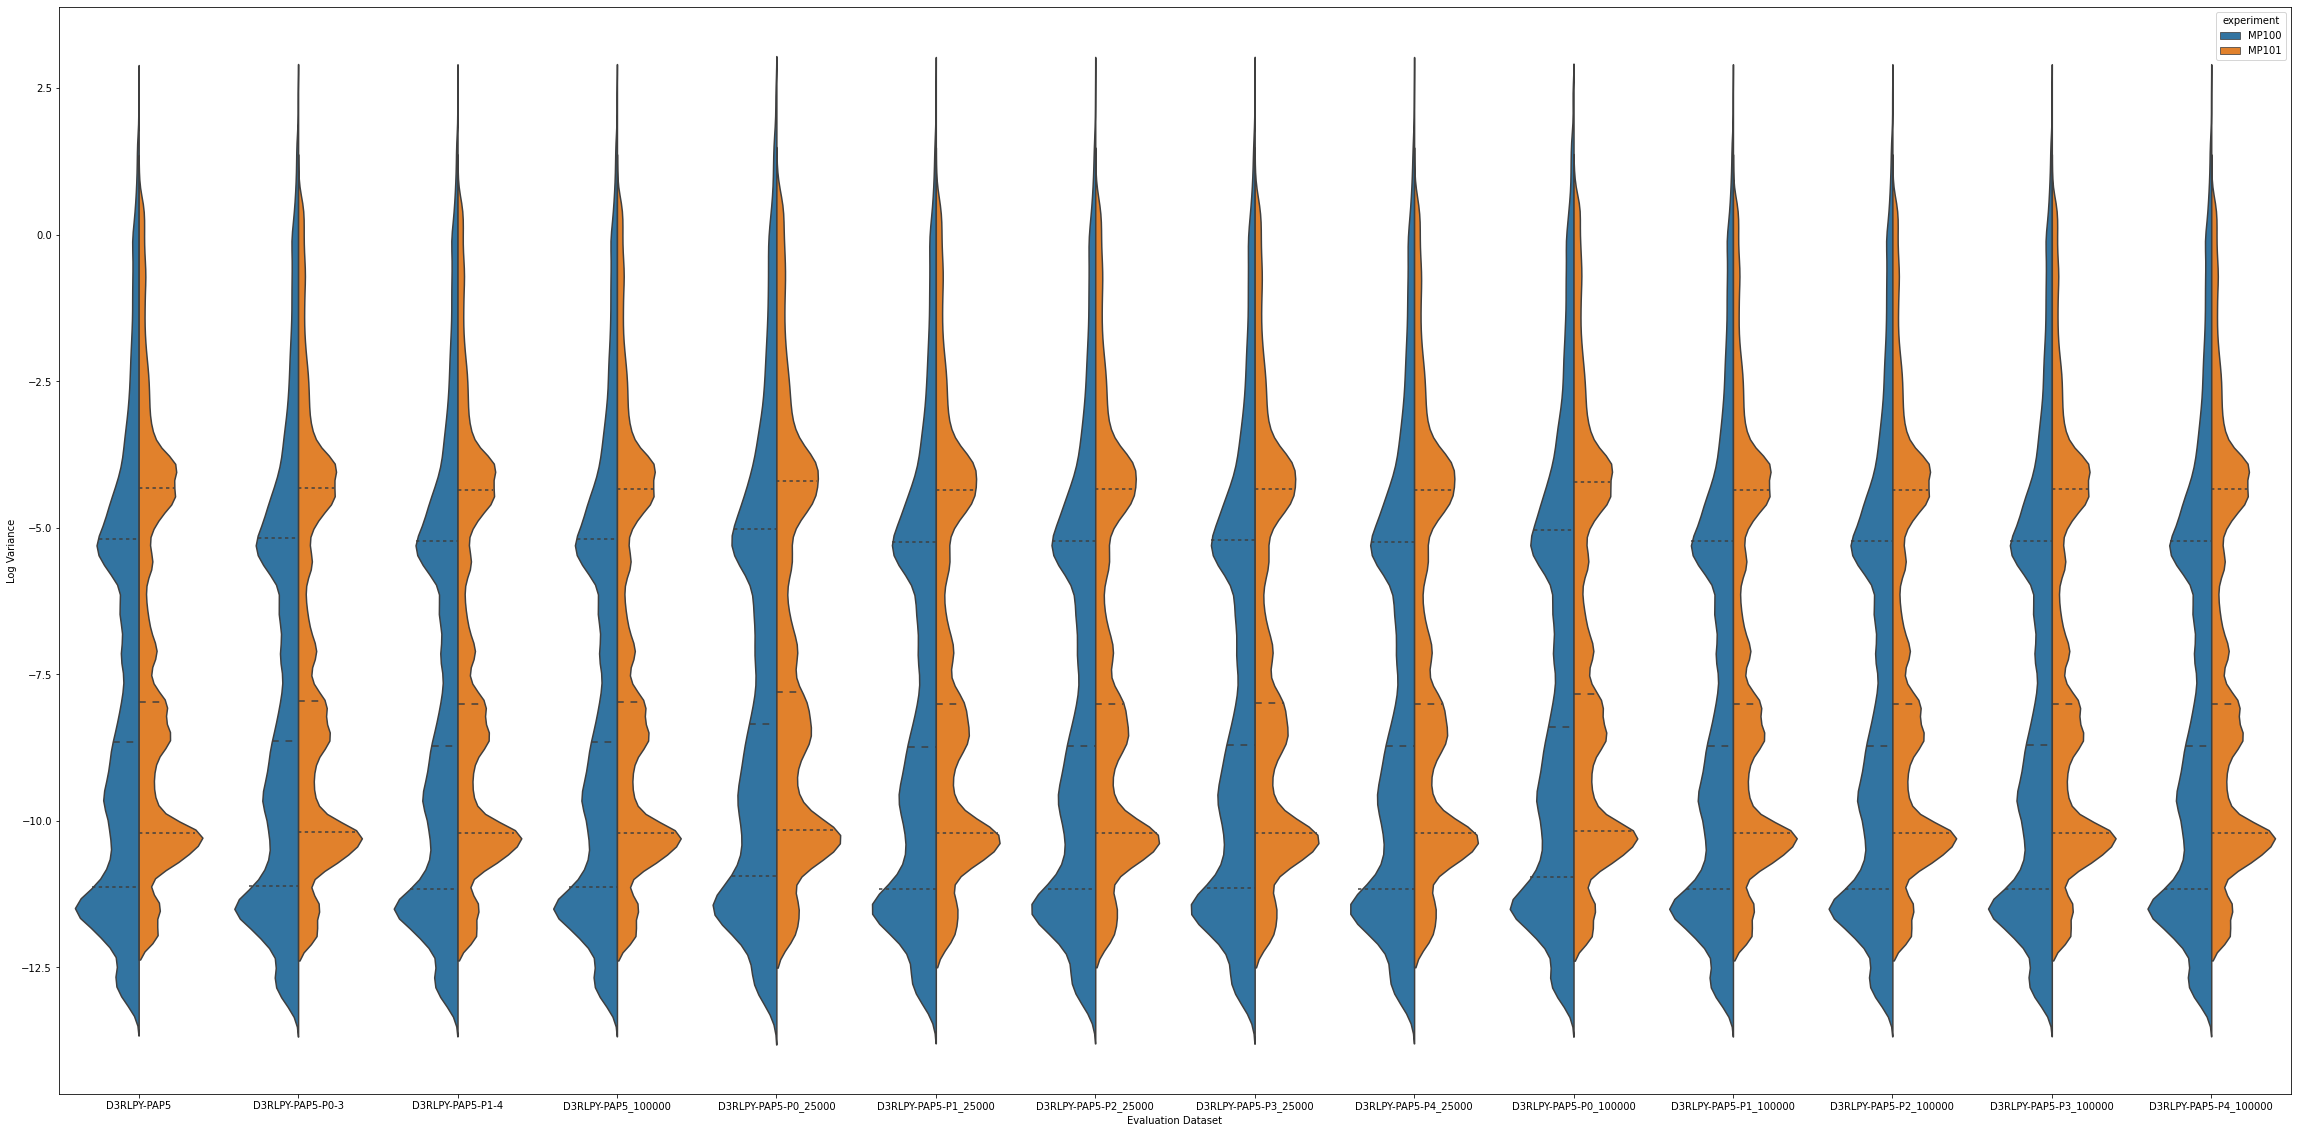

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(40,20))
sns.violinplot(
    x='dataset', y='values', hue='experiment', data=vals_df, split=True, scale="count", inner="quartile"
)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Log Variance')

## Analyse Specific Experiment Set

In [17]:
eval_dataset = 'D3RLPY-PAP5-P0_100000'
eval_data = np.load(f'../dogo_results/data/{eval_dataset}.npy')
eval_states, eval_actions, eval_next_states, eval_rewards, eval_dones, eval_policies = np.split(eval_data, ENDS, axis=1)

eval_outputs = np.concatenate((eval_rewards, eval_next_states), axis=-1)

k = eval_outputs.shape[-1]

In [18]:
exp_1, exp_2, exp_3 = 'MP100', 'MP134', 'MP101'

exp_1_means, exp_1_vars = d3rlpy_pap5_preds[exp_1][eval_dataset]['pred_means'], d3rlpy_pap5_preds[exp_1][eval_dataset]['pred_vars']
exp_2_means, exp_2_vars = d3rlpy_pap5_preds[exp_2][eval_dataset]['pred_means'], d3rlpy_pap5_preds[exp_2][eval_dataset]['pred_vars']
exp_3_means, exp_3_vars = d3rlpy_pap5_preds[exp_3][eval_dataset]['pred_means'], d3rlpy_pap5_preds[exp_3][eval_dataset]['pred_vars']

exp_1_samples = np.mean(exp_1_means, axis=0)
exp_2_samples = np.mean(exp_2_means, axis=0)
exp_3_samples = np.mean(exp_3_means, axis=0)

exp_1_pred_rewards, exp_1_pred_next_obs = exp_1_samples[:,:1], exp_1_samples[:,1:]
exp_2_pred_rewards, exp_2_pred_next_obs = exp_2_samples[:,:1], exp_2_samples[:,1:]
exp_3_pred_rewards, exp_3_pred_next_obs = exp_3_samples[:,:1], exp_3_samples[:,1:]

exp_1_norm = norm(loc=exp_1_means, scale=np.sqrt(exp_1_vars))
exp_2_norm = norm(loc=exp_2_means, scale=np.sqrt(exp_2_vars))
exp_3_norm = norm(loc=exp_3_means, scale=np.sqrt(exp_3_vars))

In [19]:
(
    exp_1_norm.logpdf(np.concatenate((eval_rewards, eval_next_states), axis=-1)).sum(-1).mean(),
    exp_2_norm.logpdf(np.concatenate((eval_rewards, eval_next_states), axis=-1)).sum(-1).mean(),
    exp_3_norm.logpdf(np.concatenate((eval_rewards, eval_next_states), axis=-1)).sum(-1).mean()
)

(40.17515081269262, 35.092248855740266, 34.90375339241074)

In [20]:
# -1/2 * (k * np.log(2*np.pi) + np.log(tmp_1_vars).sum(-1) + (np.power(np.concatenate((tmp_rewards, tmp_next_states), axis=-1)-tmp_1_means, 2)/tmp_1_vars).sum(-1))

In [21]:
(
    np.square(exp_1_pred_rewards-eval_rewards).mean(),
    np.square(exp_2_pred_rewards-eval_rewards).mean(),
    np.square(exp_3_pred_rewards-eval_rewards).mean(),
)

(0.0003804485715771727, 0.0003992033018206795, 0.0005433941723996963)

In [22]:
(
    np.square(exp_1_pred_next_obs-eval_next_states).mean(),
    np.square(exp_2_pred_next_obs-eval_next_states).mean(),
    np.square(exp_3_pred_next_obs-eval_next_states).mean()
)

(0.13751702358020068, 0.12457482686200916, 0.13380037680743306)

In [23]:
(
    np.square(exp_1_samples-eval_outputs).mean(),
    np.square(exp_2_samples-eval_outputs).mean(),
    np.square(exp_3_samples-eval_outputs).mean()
)

(0.12989832496861053, 0.11767618110866533, 0.12639721110548666)

In [24]:
(-0.5*np.log(exp_1_vars).sum(-1)).mean(), (-0.5*np.log(exp_2_vars).sum(-1)).mean(), (-0.5*np.log(exp_3_vars).sum(-1)).mean()

(70.32211, 69.196686, 63.81888)

In [25]:
exp_1_vars.mean(), exp_2_vars.mean(), exp_3_vars.mean()

(0.093016624, 0.046483714, 0.06197891)

In [26]:
np.log(exp_1_vars).sum(-1).mean(), np.log(exp_2_vars).sum(-1).mean(), np.log(exp_3_vars).sum(-1).mean()

(-140.64423, -138.39337, -127.63776)

In [27]:
(
    (-0.5*(np.power(eval_outputs-exp_1_means, 2)/exp_1_vars).sum(-1)).mean(),
    (-0.5*(np.power(eval_outputs-exp_2_means, 2)/exp_2_vars).sum(-1)).mean(),
    (-0.5*(np.power(eval_outputs-exp_3_means, 2)/exp_3_vars).sum(-1)).mean()
)

(-13.606064813880671, -17.563555840764682, -12.374240933190372)

In [28]:
(
    np.exp((-0.5*(np.power(eval_outputs-exp_1_means, 2)/exp_1_vars).sum(-1)).mean()),
    np.exp((-0.5*(np.power(eval_outputs-exp_2_means, 2)/exp_2_vars).sum(-1)).mean()),
    np.exp((-0.5*(np.power(eval_outputs-exp_3_means, 2)/exp_3_vars).sum(-1)).mean())
)

(1.2329944760507946e-06, 2.356376135732363e-08, 4.226057920178153e-06)

In [29]:
(
    (-0.5*np.log(exp_1_vars).sum(-1)).mean() + (-0.5*(np.power(eval_outputs-exp_1_means, 2)/exp_1_vars).sum(-1)).mean(),
    (-0.5*np.log(exp_2_vars).sum(-1)).mean() + (-0.5*(np.power(eval_outputs-exp_2_means, 2)/exp_2_vars).sum(-1)).mean(),
    (-0.5*np.log(exp_3_vars).sum(-1)).mean() + (-0.5*(np.power(eval_outputs-exp_3_means, 2)/exp_3_vars).sum(-1)).mean()
)

(56.716048223228704, 51.63312995025095, 51.44463724063775)

In [30]:
(
    (-0.5 * k * np.log(2*np.pi) -0.5*np.log(exp_1_vars).sum(-1)).mean() + (-0.5*(np.power(eval_outputs-exp_1_means, 2)/exp_1_vars).sum(-1)).mean(),
    (-0.5 * k * np.log(2*np.pi) -0.5*np.log(exp_2_vars).sum(-1)).mean() + (-0.5*(np.power(eval_outputs-exp_2_means, 2)/exp_2_vars).sum(-1)).mean(),
    (-0.5 * k * np.log(2*np.pi) -0.5*np.log(exp_3_vars).sum(-1)).mean() + (-0.5*(np.power(eval_outputs-exp_3_means, 2)/exp_3_vars).sum(-1)).mean()
)

(40.175162297935735, 35.09224783965524, 34.90375513004205)

In [31]:
-0.5 * k * np.log(2*np.pi)

-16.54089359768411

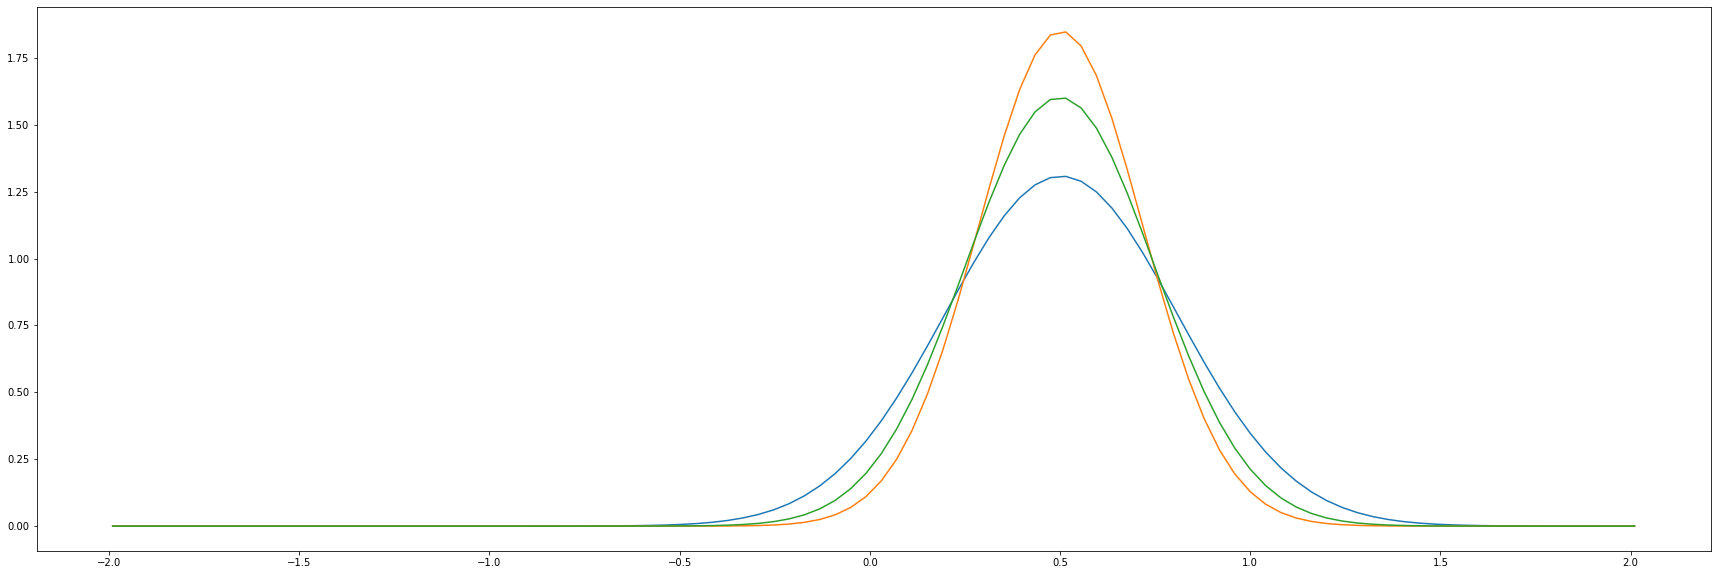

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
x_range=np.linspace(-2,2,100)+0.01
ax.plot(x_range, norm(loc=exp_1_means.mean(), scale=np.sqrt(exp_1_vars.mean())).pdf(x_range))
ax.plot(x_range, norm(loc=exp_2_means.mean(), scale=np.sqrt(exp_2_vars.mean())).pdf(x_range))
ax.plot(x_range, norm(loc=exp_3_means.mean(), scale=np.sqrt(exp_3_vars.mean())).pdf(x_range))

# D3RLPY-MP1

In [ ]:
d3rlpy_mp1_datasets = [
    "D3RLPY-MP1",
    "D3RLPY-MP1-P0-3",
    "D3RLPY-MP1-P1-4",
    "D3RLPY-MP1_100000",
    "D3RLPY-MP1-P0_25000",
    "D3RLPY-MP1-P1_25000",
    "D3RLPY-MP1-P2_25000",
    "D3RLPY-MP1-P3_25000",
    "D3RLPY-MP1-P4_25000",
    "D3RLPY-MP1-P0_100000",
    "D3RLPY-MP1-P1_100000",
    "D3RLPY-MP1-P2_100000",
    "D3RLPY-MP1-P3_100000",
    "D3RLPY-MP1-P4_100000",
]
d3rlpy_mp1_experiment_datasets = ['D3RLPY-MP1-P0-3', 'D3RLPY-MP1-P1-4']
d3rlpy_mp1_experiments = ["MP112", "MP113", "MP114", "MP115", "MP116", "MP117", "MP118", "MP119", "MP120", "MP121", "MP122", "MP123"]

In [ ]:
d3rlpy_mp1_preds = {}
d3rlpy_mp1_pred_summary = {}
for exp in d3rlpy_mp1_experiments:
    d3rlpy_mp1_preds[exp] = {}
    
    exp_details = get_experiment_details(exp)
    elites = exp_details.elites
    key = ' - '.join((exp_details.name, exp_details.dataset, f'REx: {exp_details.rex}'))
    for data in d3rlpy_mp1_datasets:
        pred_means, pred_vars = get_pred_means_and_vars(exp, data)

        d3rlpy_mp1_preds[exp][data] = {
            'pred_means': pred_means[elites,:,:],
            'pred_vars': pred_vars[elites,:,:],
        }

        d3rlpy_mp1_pred_summary[(key, data)] = {
            'rex': exp_details.rex,
            'training_dataset': exp_details.dataset,
            'seed': exp_details.seed,
            'mean_pred_means': pred_means.mean(),
            'mean_pred_vars': pred_vars.mean(),
            'std_pred_vars': pred_vars.std(),
            'median_pred_means': np.percentile(pred_means, 50),
            'median_pred_vars': np.percentile(pred_vars, 50)
        }

In [ ]:
d3rlpy_mp1_pred_summary_df = (
    pd.DataFrame().from_dict(d3rlpy_mp1_pred_summary, orient='index')[['rex', 'training_dataset', 'seed', 'mean_pred_means', 'mean_pred_vars', 'std_pred_vars', 'median_pred_means', 'median_pred_vars']].
    reset_index().rename(columns={'level_0': 'key', 'level_1': 'evaluation_dataset'})
)

In [ ]:
d3rlpy_mp1_preds_groups = (
    d3rlpy_mp1_pred_summary_df[['rex', 'training_dataset', 'evaluation_dataset', 'seed', 'mean_pred_means', 'mean_pred_vars', 'std_pred_vars', 'median_pred_means', 'median_pred_vars']].
    groupby(['rex', 'training_dataset', 'evaluation_dataset'])
    # groupby(['rex', 'training_dataset', 'evaluation_dataset'])
)
d3rlpy_mp1_preds_avgs_df = d3rlpy_mp1_preds_groups.mean().reset_index()
d3rlpy_mp1_preds_stds_df = d3rlpy_mp1_preds_groups.std().reset_index().replace(np.NaN, 0)
d3rlpy_mp1_preds_mins_df = d3rlpy_mp1_preds_groups.min().reset_index().replace(np.NaN, 0)
d3rlpy_mp1_preds_maxes_df = d3rlpy_mp1_preds_groups.max().reset_index().replace(np.NaN, 0)

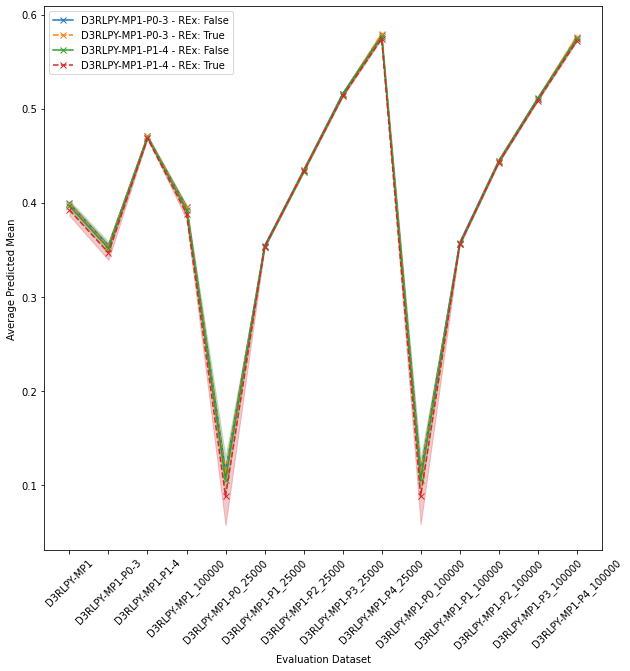

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

metric = 'mean_pred_means'
training_datasets = d3rlpy_mp1_experiment_datasets
evaluation_datasets = d3rlpy_mp1_datasets
for t_ds in training_datasets:
    for rex in [False, True]:
        mask = (
            (d3rlpy_mp1_preds_avgs_df['training_dataset'] == t_ds) &
            (d3rlpy_mp1_preds_avgs_df['rex'] == rex) &
            # (d3rlpy_mp1_preds_avgs_df['seed'] == 4321) &
            (d3rlpy_mp1_preds_avgs_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
        )
        plot_means = d3rlpy_mp1_preds_avgs_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_mins = d3rlpy_mp1_preds_mins_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_maxes = d3rlpy_mp1_preds_maxes_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        label = f'{t_ds} - REx: {rex}'
        p = ax.plot(evaluation_datasets, plot_means, label=label, marker='x', ls='--' if rex else '-')
        ax.fill_between(evaluation_datasets, plot_mins, plot_maxes, color=p[0].get_color(), alpha=0.25)
ax.set_xticks(ax.get_xticks(), evaluation_datasets, rotation=45)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Average Predicted Mean')
ax.legend()

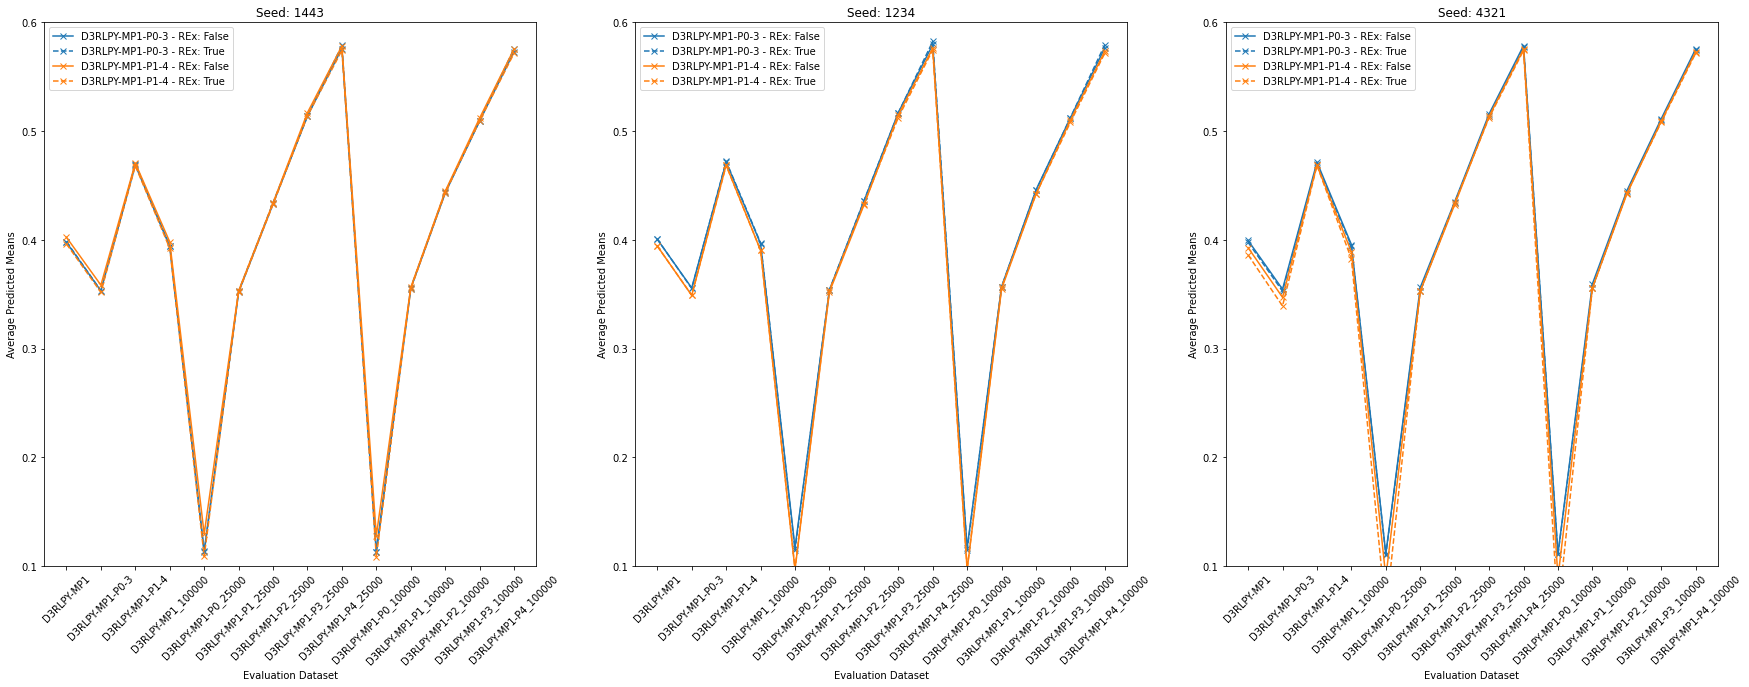

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'mean_pred_means'
training_datasets = ['D3RLPY-MP1-P0-3', 'D3RLPY-MP1-P1-4']
evaluation_datasets = d3rlpy_mp1_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex in [False, True]:
            mask = (
                (d3rlpy_mp1_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_mp1_pred_summary_df['rex'] == rex) &
                (d3rlpy_mp1_pred_summary_df['seed'] == seed) &
                (d3rlpy_mp1_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_mp1_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Average Predicted Means')
    ax[i].set_ylim(0.1, 0.6)
    ax[i].legend()

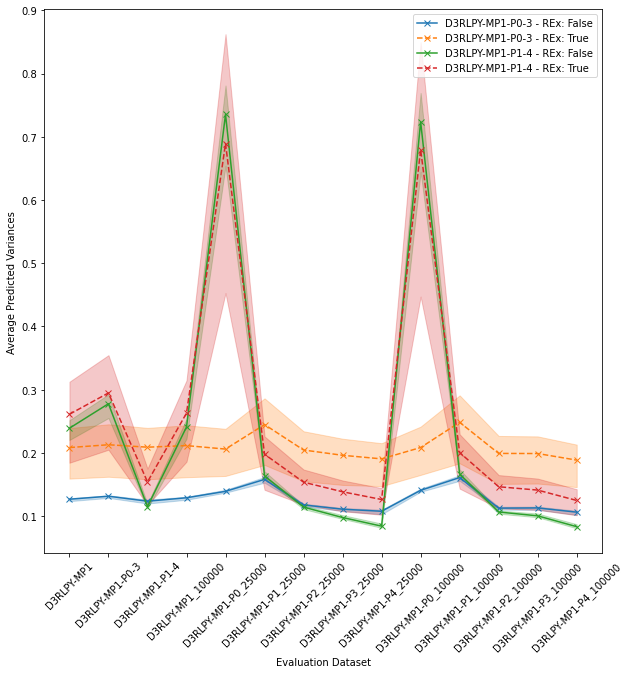

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

metric = 'mean_pred_vars'
training_datasets = d3rlpy_mp1_experiment_datasets
evaluation_datasets = d3rlpy_mp1_datasets
for t_ds in training_datasets:
    for rex in [False, True]:
        mask = (
            (d3rlpy_mp1_preds_avgs_df['training_dataset'] == t_ds) &
            (d3rlpy_mp1_preds_avgs_df['rex'] == rex) &
            # (d3rlpy_mp1_preds_avgs_df['seed'] == 4321) &
            (d3rlpy_mp1_preds_avgs_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
        )
        plot_means = d3rlpy_mp1_preds_avgs_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_mins = d3rlpy_mp1_preds_mins_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        plot_maxes = d3rlpy_mp1_preds_maxes_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
        label = f'{t_ds} - REx: {rex}'
        p = ax.plot(evaluation_datasets, plot_means, label=label, marker='x', ls='--' if rex else '-')
        ax.fill_between(evaluation_datasets, plot_mins, plot_maxes, color=p[0].get_color(), alpha=0.25)
ax.set_xticks(ax.get_xticks(), evaluation_datasets, rotation=45)
ax.set_xlabel('Evaluation Dataset')
ax.set_ylabel('Average Predicted Variances')
ax.legend()

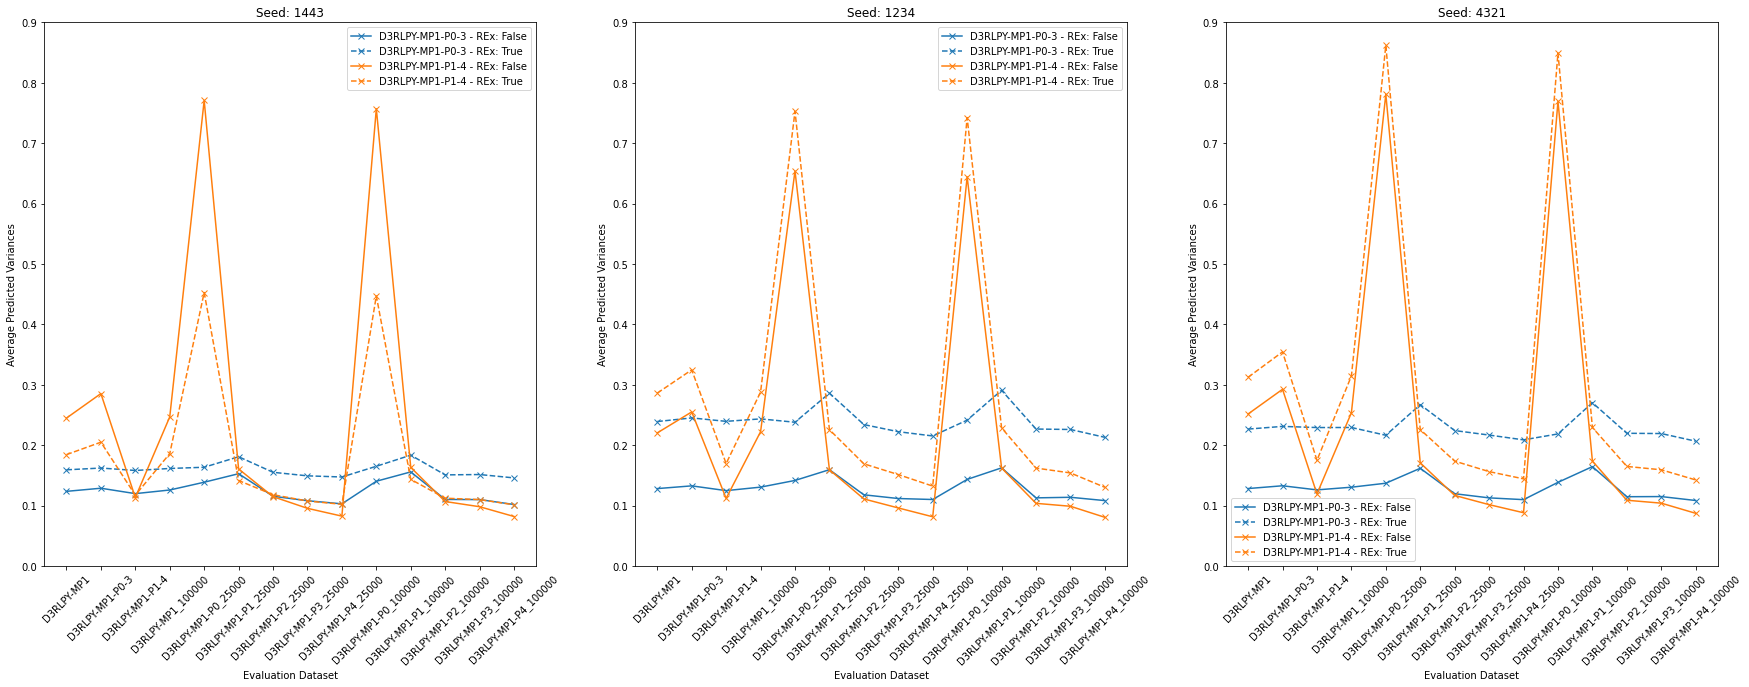

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'mean_pred_vars'
training_datasets = ['D3RLPY-MP1-P0-3', 'D3RLPY-MP1-P1-4']
evaluation_datasets = d3rlpy_mp1_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex in [False, True]:
            mask = (
                (d3rlpy_mp1_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_mp1_pred_summary_df['rex'] == rex) &
                (d3rlpy_mp1_pred_summary_df['seed'] == seed) &
                (d3rlpy_mp1_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_mp1_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Average Predicted Variances')
    ax[i].set_ylim(0, 0.9)
    ax[i].legend()

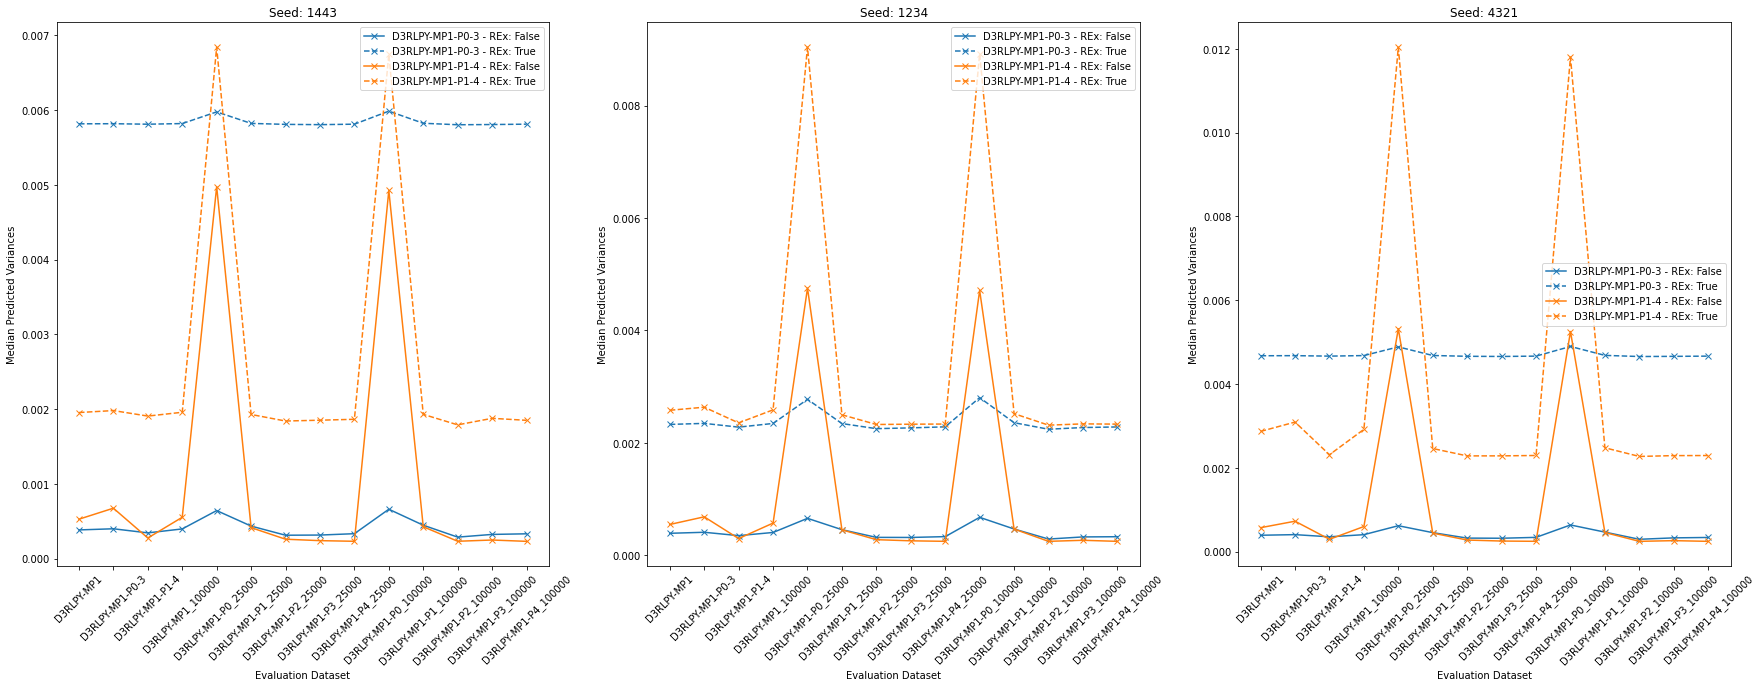

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'median_pred_vars'
training_datasets = ['D3RLPY-MP1-P0-3', 'D3RLPY-MP1-P1-4']
evaluation_datasets = d3rlpy_mp1_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex in [False, True]:
            mask = (
                (d3rlpy_mp1_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_mp1_pred_summary_df['rex'] == rex) &
                (d3rlpy_mp1_pred_summary_df['seed'] == seed) &
                (d3rlpy_mp1_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_mp1_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Median Predicted Variances')
    # ax[i].set_ylim(0, 0.9)
    ax[i].legend()

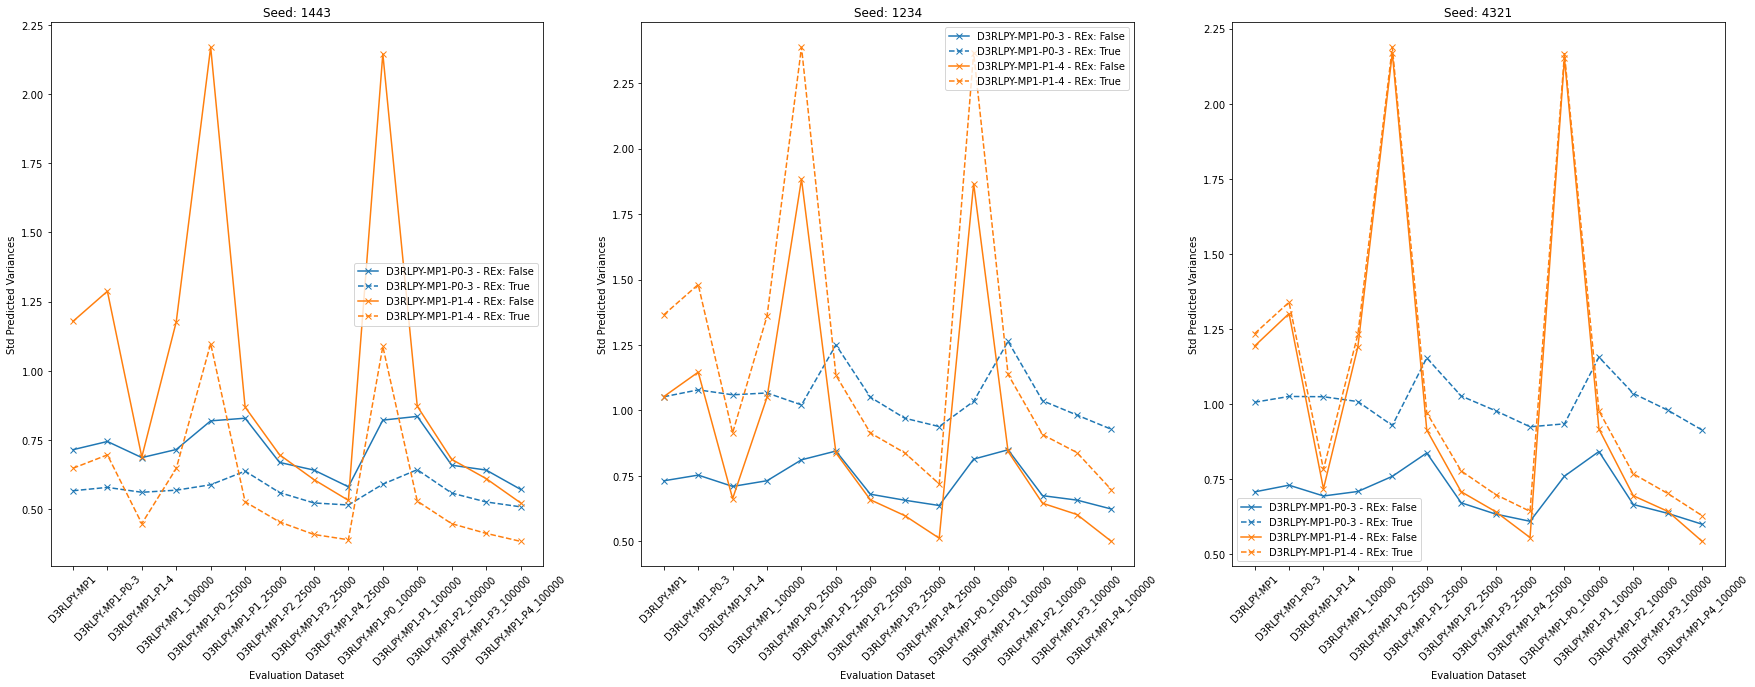

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

metric = 'std_pred_vars'
training_datasets = ['D3RLPY-MP1-P0-3', 'D3RLPY-MP1-P1-4']
evaluation_datasets = d3rlpy_mp1_datasets

for i, seed in enumerate([1443, 1234, 4321]):
    for t_ds in training_datasets:
        for rex in [False, True]:
            mask = (
                (d3rlpy_mp1_pred_summary_df['training_dataset'] == t_ds) &
                (d3rlpy_mp1_pred_summary_df['rex'] == rex) &
                (d3rlpy_mp1_pred_summary_df['seed'] == seed) &
                (d3rlpy_mp1_pred_summary_df['evaluation_dataset'].isin(evaluation_datasets)), ['evaluation_dataset' , metric]
            )
            plot_vals = d3rlpy_mp1_pred_summary_df.loc[mask].set_index('evaluation_dataset').loc[evaluation_datasets][metric]
            label = f'{t_ds} - REx: {rex}'
            p = ax[i].plot(evaluation_datasets, plot_vals, label=label, marker='x', ls='--' if rex else '-', c=p[0].get_color() if rex else None)
    ax[i].set_xticks(ax[i].get_xticks(), evaluation_datasets, rotation=45)
    ax[i].set_title(f'Seed: {seed}')
    ax[i].set_xlabel('Evaluation Dataset')
    ax[i].set_ylabel('Std Predicted Variances')
    # ax[i].set_ylim(0, 0.9)
    ax[i].legend()

In [ ]:
exp_1 = 'MP112'
exp_2 = 'MP113'
val_arr, experiment_arr, dataset_arr = np.array([]), np.array([]), np.array([])
for data in d3rlpy_mp1_datasets:
    vals_1 = d3rlpy_mp1_preds[exp_1][data]['pred_vars'].mean(axis=0).flatten()
    vals_2 = d3rlpy_mp1_preds[exp_2][data]['pred_vars'].mean(axis=0).flatten()

    val_arr = np.hstack((val_arr, np.log(vals_1), np.log(vals_2)))
    experiment_arr = np.hstack((experiment_arr, np.full(len(vals_1), exp_1), np.full(len(vals_2), exp_2)))
    dataset_arr = np.hstack((dataset_arr, np.full(len(vals_1), data), np.full(len(vals_2), data)))

In [ ]:
vals_df = pd.DataFrame({
    'values': val_arr,
    'experiment': experiment_arr,
    'dataset': dataset_arr,
})

<AxesSubplot:xlabel='dataset', ylabel='values'>

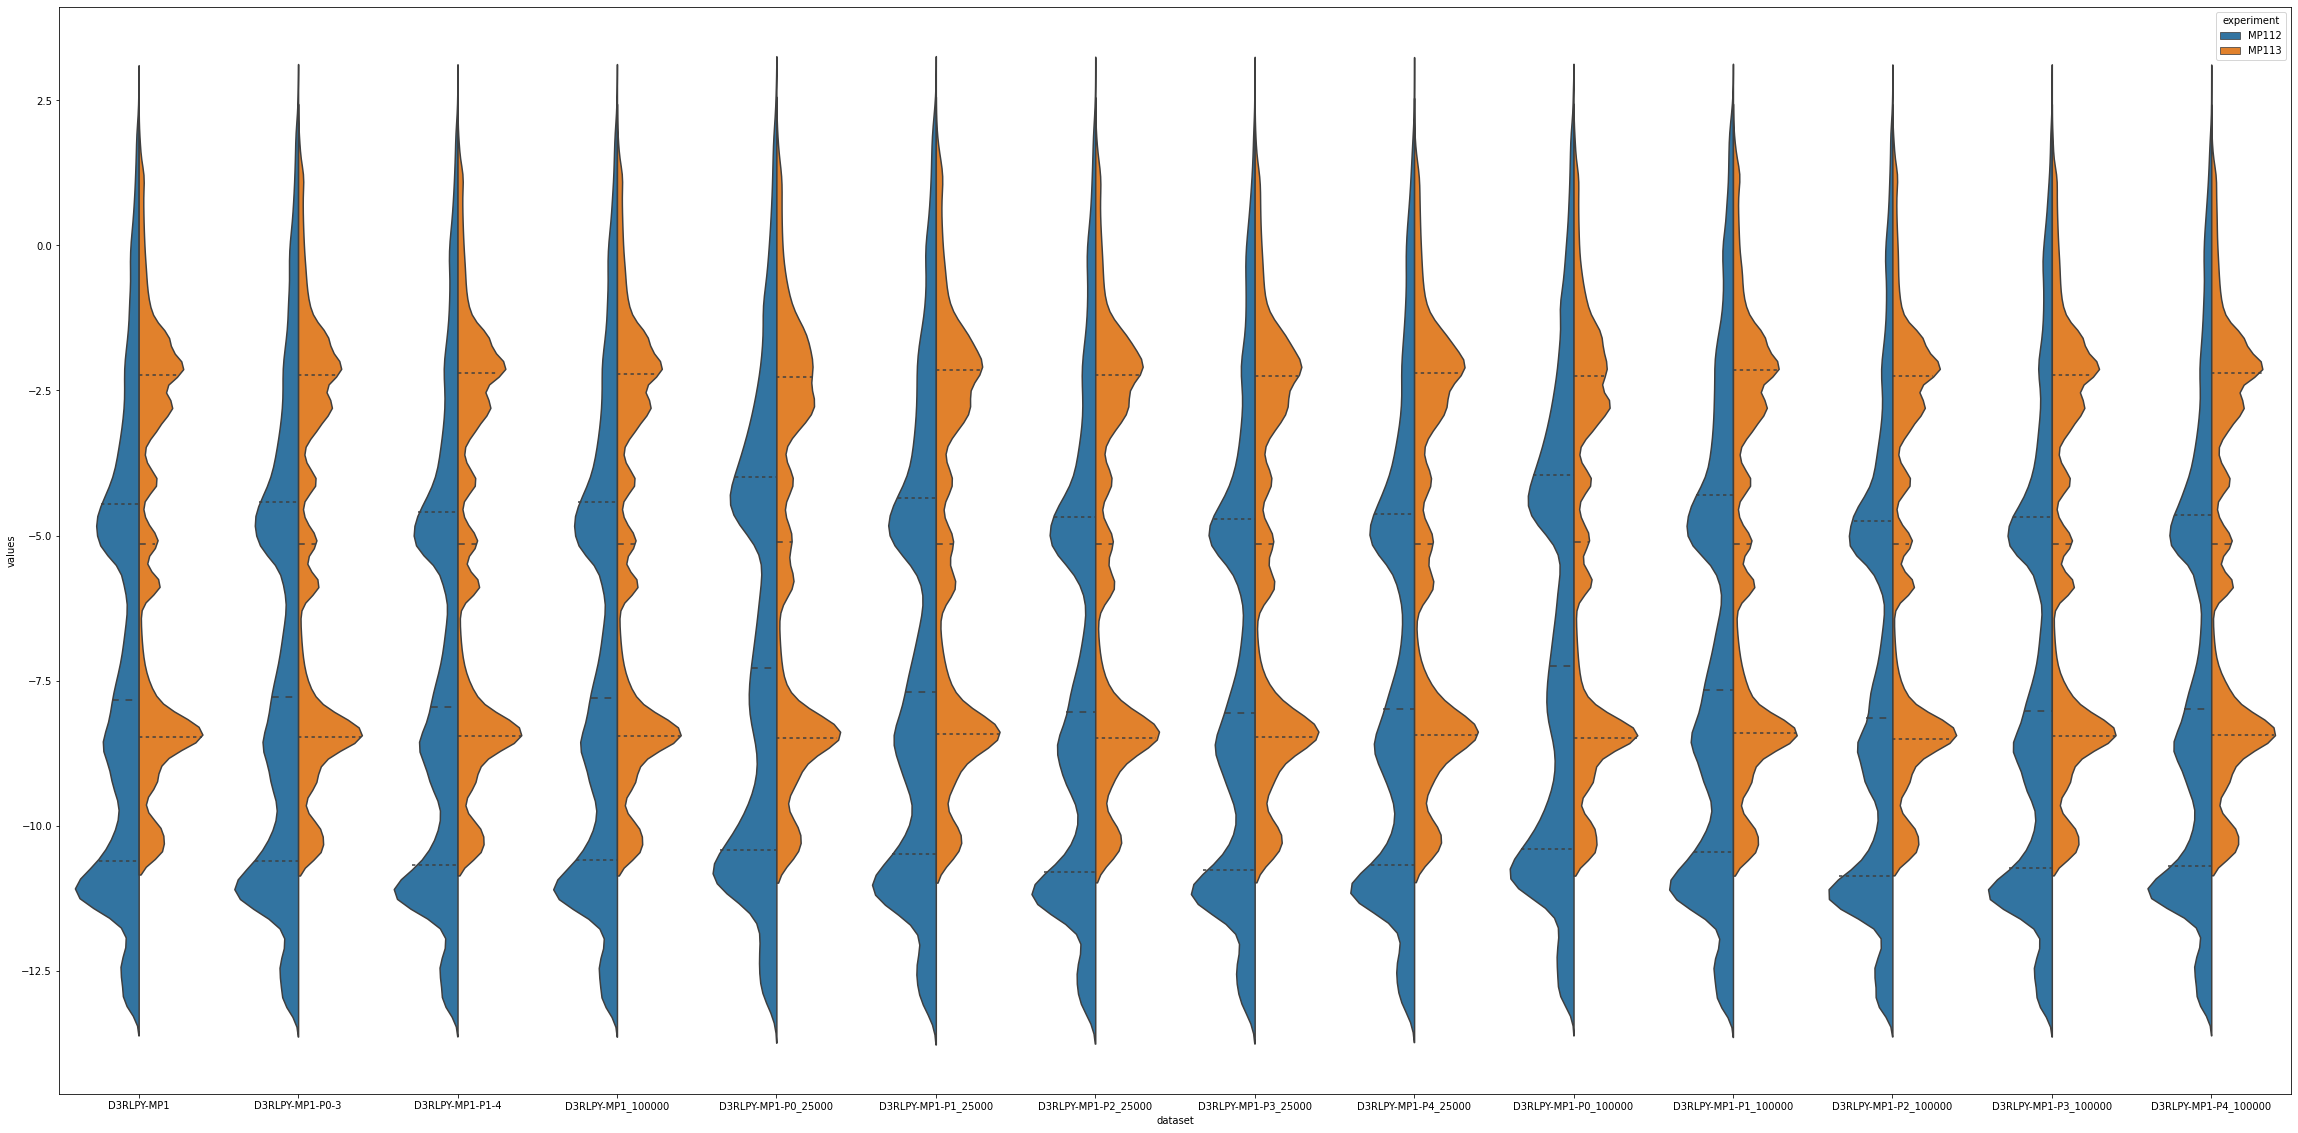

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(40,20))
sns.violinplot(
    x='dataset', y='values', hue='experiment', data=vals_df, split=True, scale="count", inner="quartile"
)